In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import shap
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from pyswarms.single.global_best import GlobalBestPSO 

In [8]:
df = pd.read_csv('mw_pw_profiles.csv')

In [9]:
import numpy as np

# 1️⃣  Replace NaNs with 0 so comparisons don’t break
df[['fantasy_score_batting', 'fantasy_score_bowling', 'stumpings_done']] = (
    df[['fantasy_score_batting', 'fantasy_score_bowling', 'stumpings_done']]
    .fillna(0)
)

# 2️⃣  Role‑assignment function
def classify_player(row):
    bat   = row['fantasy_score_batting']
    bowl  = row['fantasy_score_bowling']
    stump = row['stumpings_done']

    # wicketkeeper first (takes priority)
    if stump > 0:
        return 'wicketkeeper'

    # genuine all‑rounder: both scores present & reasonably similar
    if bat > 0 and bowl > 0 and min(bat, bowl) >= 0.5 * max(bat, bowl):
        return 'allrounder'

    # otherwise whichever score is larger decides
    if bat >= bowl:
        return 'batsman'          # ties go to batsman
    else:
        return 'bowler'

# 3️⃣  Apply
df['player_role'] = df.apply(classify_player, axis=1)


In [10]:
df_processed = pd.read_csv('features.csv')

In [11]:
df_processed['player_role'] = df['player_role']

In [12]:
df_processed

,player_id,match_id,start_date,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,runs_scored_1,...,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,fantasy_score_total_1,fantasy_score_total_5,fantasy_score_total_10,order_seen,player_role
0,11182,63963,2001-12-19,49,0,0,0,0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,7,allrounder
1,1878,63963,2001-12-19,44,0,0,0,0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0,batsman
2,10153,63963,2001-12-19,84,0,0,0,0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,6,batsman
3,11344,63963,2001-12-19,62,0,0,0,0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3,batsman
4,10707,63963,2001-12-19,38,0,0,0,0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2,bowler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,1587,1462374,2025-05-20,42,0,0,1,0,0,15.0,...,60.759616,61.218945,130.000000,129.720810,117.963983,17.0,20.534860,24.246493,2,batsman
416708,7111,1462374,2025-05-20,96,0,0,1,0,0,13.0,...,102.067592,111.696603,50.000000,73.167167,86.093758,43.0,73.162445,64.412105,7,bowler
416709,10032,1462374,2025-05-20,13,0,0,1,0,0,2.0,...,54.717084,59.898700,62.903226,88.238688,91.650894,70.0,56.482568,49.700626,8,batsman
416710,10220,1473500,2025-05-20,16,0,0,0,1,0,0.0,...,67.248226,77.942114,0.000000,0.000000,0.000000,10.0,33.372753,39.941265,2,batsman


In [13]:
df_processed['player_id'] = df['player_id']

In [14]:
df_processed

,player_id,match_id,start_date,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,runs_scored_1,...,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,fantasy_score_total_1,fantasy_score_total_5,fantasy_score_total_10,order_seen,player_role
0,00015688,63963,2001-12-19,49,0,0,0,0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,7,allrounder
1,00015688,63963,2001-12-19,44,0,0,0,0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0,batsman
2,00015688,63963,2001-12-19,84,0,0,0,0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,6,batsman
3,00015688,63963,2001-12-19,62,0,0,0,0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3,batsman
4,00015688,63963,2001-12-19,38,0,0,0,0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2,bowler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,fffa744b,1462374,2025-05-20,42,0,0,1,0,0,15.0,...,60.759616,61.218945,130.000000,129.720810,117.963983,17.0,20.534860,24.246493,2,batsman
416708,fffa744b,1462374,2025-05-20,96,0,0,1,0,0,13.0,...,102.067592,111.696603,50.000000,73.167167,86.093758,43.0,73.162445,64.412105,7,bowler
416709,fffa744b,1462374,2025-05-20,13,0,0,1,0,0,2.0,...,54.717084,59.898700,62.903226,88.238688,91.650894,70.0,56.482568,49.700626,8,batsman
416710,fffa744b,1473500,2025-05-20,16,0,0,0,1,0,0.0,...,67.248226,77.942114,0.000000,0.000000,0.000000,10.0,33.372753,39.941265,2,batsman


In [15]:
df_processed['start_date'] = pd.to_datetime(df_processed['start_date'])

cutoff_date = pd.to_datetime('2024-07-01')

train_df_features = df_processed[df_processed['start_date'] < cutoff_date]
test_df_features = df_processed[df_processed['start_date'] >= cutoff_date]

In [16]:
X_train = train_df_features.drop(['fantasy_score_total', 'match_id', 'start_date', 'player_role','player_id'], axis = 1)
y_train = train_df_features['fantasy_score_total']

In [17]:
model3 = XGBRegressor(n_estimators=100, random_state=42)

In [18]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [19]:
rfecv = RFECV(estimator=model3, step = 1, cv=5, scoring = 'neg_mean_squared_error', n_jobs = -1)
rfecv.fit(X_train_scaled, y_train)

RFECV(cv=5,
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, device=None,
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, feature_weights=None,
                             gamma=None, grow_policy=None, importance_type=None,
                             interaction_constraints=None, learning_rate=None,
                             max_bin=None, max_cat_threshold=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=None, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, multi_strategy=None,
                             n_estimators=100, n_jobs=None,
                             num_parallel_tree=None, ...),
      n_jobs=-1, scoring='neg_mean_squared_error')

In [20]:
print(f"Number of optimal features: {rfecv.n_features_}")
print("Selected features:", X_train.columns[rfecv.support_].tolist())

Number of optimal features: 19
Selected features: ['match_type_MDM', 'match_type_ODI', 'match_type_T20', 'match_type_Test', 'sixes_scored_5', 'sixes_scored_10', 'run_out_direct_10', 'run_out_throw_10', 'wickets_taken_5', 'wickets_taken_10', 'bowled_done_10', 'lbw_done_10', 'maidens_10', 'strike_rate_5', 'strike_rate_10', 'economy_rate_10', 'fantasy_score_total_5', 'fantasy_score_total_10', 'order_seen']


In [21]:
X_train_selected = rfecv.transform(X_train_scaled)

In [22]:
model3.fit(X_train_selected, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

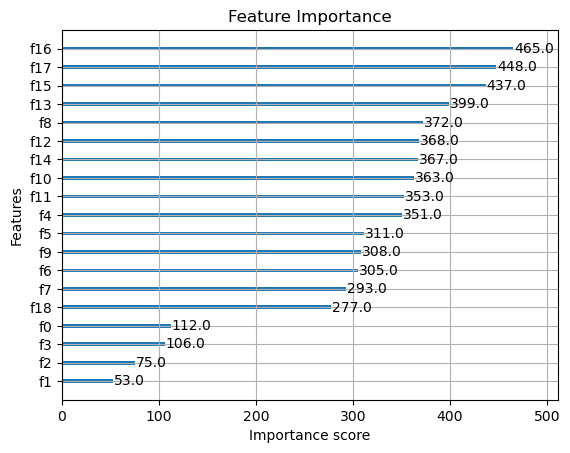

In [23]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(model3, max_num_features=19, importance_type='weight')  # or 'gain', 'cover', etc.
plt.title("Feature Importance")
plt.show()

In [24]:
X_test = test_df_features.drop(['fantasy_score_total', 'match_id', 'start_date','player_role', 'player_id'], axis = 1)
y_test = test_df_features['fantasy_score_total']

In [25]:
X_test_scaled = scaler.fit_transform(X_test)

In [26]:
X_test_selected = rfecv.transform(X_test_scaled)

In [27]:
fantasy_score_total_predicted = model3.predict(X_test_selected)

In [28]:
print("RMSE:", mean_squared_error(y_test, fantasy_score_total_predicted))
print("R² Score:", r2_score(y_test, fantasy_score_total_predicted))

RMSE: 1482.562255859375
R² Score: 0.1476842164993286


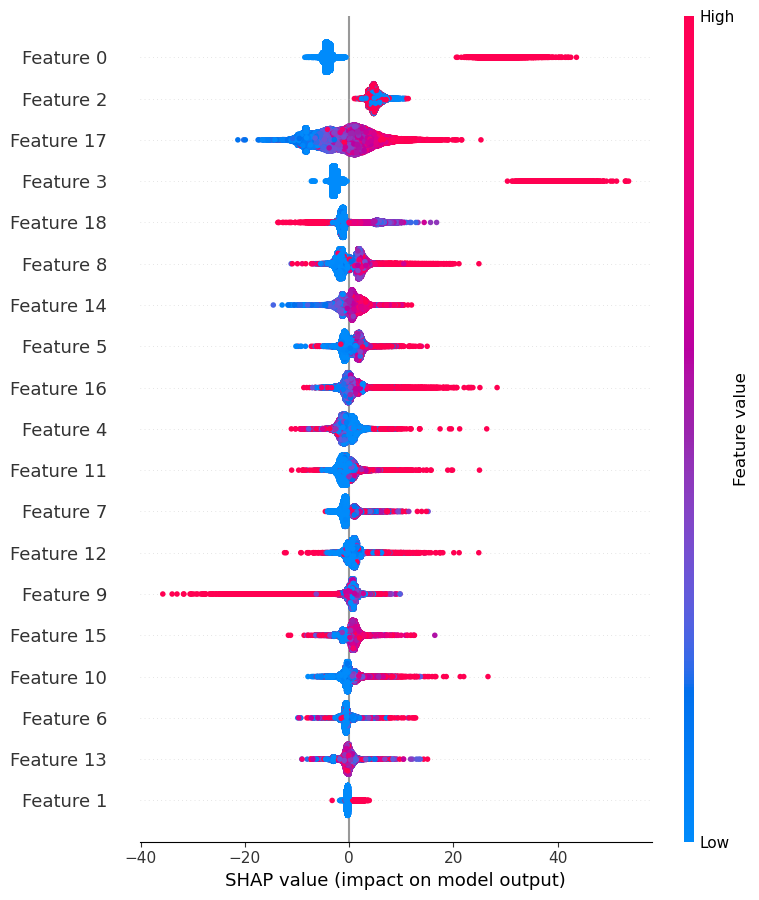

In [29]:
explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(X_test_selected)
shap.summary_plot(shap_values, X_test_selected)

In [30]:
test_df_features['predicted_fantasy_score_total_exp'] = fantasy_score_total_predicted

In [31]:
test_df_features

,player_id,match_id,start_date,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,runs_scored_1,...,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,fantasy_score_total_1,fantasy_score_total_5,fantasy_score_total_10,order_seen,player_role,predicted_fantasy_score_total_exp
373280,e6e9b619,1428459,2024-07-01,-2,0,0,0,1,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0,batsman,27.912971
373281,e6e9b619,1428459,2024-07-01,37,0,0,0,1,0,17.0,...,84.834163,60.000000,77.926510,118.273870,40.0,64.551465,69.990731,0,batsman,52.487293
373282,e6e9b619,1428459,2024-07-01,66,0,0,0,1,0,30.0,...,115.886211,142.857143,117.242389,117.274969,49.0,43.665008,47.919108,0,batsman,45.375881
373283,e6e9b619,1428459,2024-07-01,17,0,0,0,1,0,14.0,...,107.225549,183.333333,181.815265,154.509818,27.0,26.978202,29.139921,3,allrounder,43.766445
373284,e6ec6b42,1428459,2024-07-01,27,0,0,0,1,0,2.0,...,59.516571,200.000000,179.045005,166.334452,27.0,26.090817,29.239260,0,allrounder,42.636692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,fffa744b,1462374,2025-05-20,42,0,0,1,0,0,15.0,...,61.218945,130.000000,129.720810,117.963983,17.0,20.534860,24.246493,2,batsman,34.654881
416708,fffa744b,1462374,2025-05-20,96,0,0,1,0,0,13.0,...,111.696603,50.000000,73.167167,86.093758,43.0,73.162445,64.412105,7,bowler,54.275990
416709,fffa744b,1462374,2025-05-20,13,0,0,1,0,0,2.0,...,59.898700,62.903226,88.238688,91.650894,70.0,56.482568,49.700626,8,batsman,52.170822
416710,fffa744b,1473500,2025-05-20,16,0,0,0,1,0,0.0,...,77.942114,0.000000,0.000000,0.000000,10.0,33.372753,39.941265,2,batsman,49.129463


In [32]:
import pandas as pd

K = 11
def evaluate_match(df, k=K):
   
    actual_top_k_sum = df['fantasy_score_total'].nlargest(k).sum()

    idx_exp1 = df['predicted_fantasy_score_total_exp'].nlargest(k).index
   
    return pd.Series({
        'actual_top_11_sum': actual_top_k_sum,
        'model1_actual_sum': df.loc[idx_exp1, 'fantasy_score_total'].sum(),
        'model1_%_of_optimal': df.loc[idx_exp1, 'fantasy_score_total'].sum() / actual_top_k_sum,
    })

evaluation_df = (
    test_df_features
    .groupby('match_id', group_keys=False)  
    .apply(evaluate_match)
    .reset_index()
)



In [33]:
evaluation_df

,match_id,actual_top_11_sum,model1_actual_sum,model1_%_of_optimal
0,1385691,1147.0,730.0,0.636443
1,1385692,1849.0,1495.0,0.808545
2,1385693,1389.0,755.0,0.543557
3,1385694,1590.0,986.0,0.620126
4,1385695,1671.0,1470.0,0.879713
...,...,...,...,...
1960,1484052,762.0,551.0,0.723097
1961,1485778,649.0,402.0,0.619414
1962,1486225,846.0,680.0,0.803783
1963,1486227,688.0,590.0,0.857558


In [34]:
evaluation_df['absolute_percentage_error_exp'] = (
    (evaluation_df['model1_actual_sum'] - evaluation_df['actual_top_11_sum']).abs() /
    evaluation_df['actual_top_11_sum']
) * 100

In [35]:
evaluation_df

,match_id,actual_top_11_sum,model1_actual_sum,model1_%_of_optimal,absolute_percentage_error_exp
0,1385691,1147.0,730.0,0.636443,36.355711
1,1385692,1849.0,1495.0,0.808545,19.145484
2,1385693,1389.0,755.0,0.543557,45.644348
3,1385694,1590.0,986.0,0.620126,37.987421
4,1385695,1671.0,1470.0,0.879713,12.028725
...,...,...,...,...,...
1960,1484052,762.0,551.0,0.723097,27.690289
1961,1485778,649.0,402.0,0.619414,38.058552
1962,1486225,846.0,680.0,0.803783,19.621749
1963,1486227,688.0,590.0,0.857558,14.244186


In [36]:
mean_absolute_percentage_error = evaluation_df['absolute_percentage_error_exp'].mean()
print(f"Mean absolute percentage error across all matches : {mean_absolute_percentage_error}%" )

Mean absolute percentage error across all matches : 29.08062554480078%


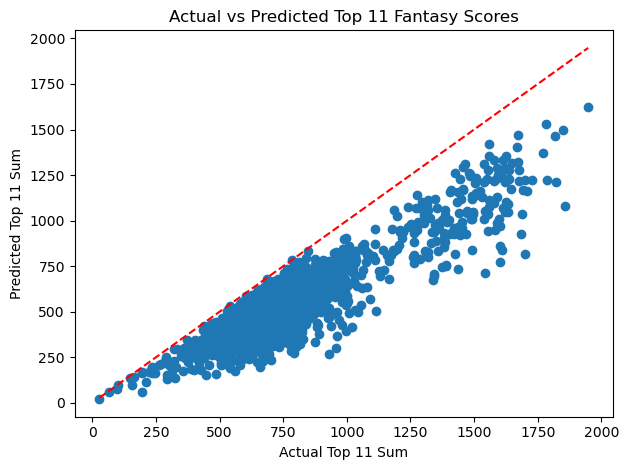

In [37]:
plt.scatter(
    evaluation_df['actual_top_11_sum'],
    evaluation_df['model1_actual_sum'],
)
plt.plot([evaluation_df['actual_top_11_sum'].min(), evaluation_df['actual_top_11_sum'].max()],
         [evaluation_df['actual_top_11_sum'].min(), evaluation_df['actual_top_11_sum'].max()],
         color='red', linestyle='--')

plt.xlabel('Actual Top 11 Sum')
plt.ylabel('Predicted Top 11 Sum')
plt.title('Actual vs Predicted Top 11 Fantasy Scores')

plt.tight_layout()
plt.show()

In [ ]:
def predict_gradio(player_ids, player_teamed, opponent_teamed) :
    predicted_data = []
    for player_id in player_ids:
        data = df_processed.groupby('player_id').get_group(player_id)
        data = data.drop(['fantasy_score_total', 'match_id', 'start_date', 'player_role', 'player_id'], axis=1)
        data_scaled = scaler.transform(data)
        data_selected = rfecv.transform(data_scaled)
        
        prediction = model3.predict(data_selected)
        data['player_role'] = df_processed[df_processed['player_id'] == player_id]['player_role'].values
        data['player_team'] = df[df['player_id'] == player_id]['player_team'].values

        predicted_data.append({
            'player_id': player_id,
            'predicted_fantasy_score_total_exp': prediction[-1],
            'player_role': data['player_role'].values[0],
            'player_team': player_teamed if 'Australia' in data['player_team'].values else opponent_teamed
        })

    

    return predicted_data


In [39]:
import pandas as pd

In [40]:
australia_players = pd.read_csv('australlia_players.csv')
west_id = pd.read_csv('west_indies_players.csv')
player_ids_australia = australia_players['player_id'].tolist()
player_ids_west_indies = west_id['player_id'].tolist()

predicted = pd.DataFrame(data=predict_gradio(player_ids_australia + player_ids_west_indies, 'Australia', 'West Indies'))

predicted.sort_values(by='predicted_fantasy_score_total_exp', ascending=False, inplace=True)

In [41]:
predicted['player_name'] = predicted['player_id'].apply(
    lambda x: australia_players[australia_players['player_id'] == x]['unique_name'].values[0] if x in player_ids_australia else
    west_id[west_id['player_id'] == x]['unique_name'].values[0])

In [43]:
predicted.head(14)

,player_id,predicted_fantasy_score_total_exp,player_role,player_team,player_name
0,69d03465,41.212555,bowler,Australia,At Carey
1,56b93d46,55.322151,bowler,Australia,Bj Webster
2,eaa76d3c,45.247669,bowler,Australia,C Green
3,989889ff,44.258297,bowler,Australia,Jp Inglis
4,03806cf8,38.760517,bowler,Australia,Jr Hazlewood
5,fa433be6,40.875721,bowler,Australia,M Labuschagne
6,3fb19989,35.235020,bowler,Australia,Ma Starc
7,7b953689,55.637665,bowler,Australia,Mp Kuhnemann
8,96a6a7ad,27.912971,bowler,Australia,Nm Lyon
9,ded9240e,35.537334,bowler,Australia,Pj Cummins


Exception ignored in: <function ResourceTracker.__del__ at 0x7540e8e674c0>
Traceback (most recent call last):
  File "/home/soumya/anaconda3/envs/win_factor/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/soumya/anaconda3/envs/win_factor/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/soumya/anaconda3/envs/win_factor/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7149ffd934c0>
Traceback (most recent call last):
  File "/home/soumya/anaconda3/envs/win_factor/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/soumya/anaconda3/envs/win_factor/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/soumya/anaconda3/envs/win_factor/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
Chi

In [49]:
print(player_ids_australia+ player_ids_west_indies)

['69d03465', '56b93d46', 'eaa76d3c', '989889ff', '03806cf8', 'fa433be6', '3fb19989', '7b953689', '96a6a7ad', 'ded9240e', '3c34c9e1', '1a2676c5', 'd167edd3', '30a45b23', '12b610c2', '331ea488', 'b0946605', '7fca84b7', 'cc23e91e', 'ded9ff1e', '74d12124', '7d5af2ea', '6020a3c6', '1d8c298b', '3feda4fa', '97290faf', '1fc6ef83', 'f0f8f105']


In [46]:
print(player_ids_west_indies)

['b0946605', '7fca84b7', 'cc23e91e', 'ded9ff1e', '74d12124', '7d5af2ea', '6020a3c6', '1d8c298b', '3feda4fa', '97290faf', '1fc6ef83', 'f0f8f105']


In [ ]:
import gradio as gr
import pandas as pd


red_theme = gr.themes.Soft(primary_hue="red")

with gr.Blocks(title="Dream11 Team Prediction System", theme=red_theme) as demo:
    gr.Markdown(
        "<h1 style='text-align:center; margin-bottom:0.2em;'>Dream11 Team Prediction System</h1>"
        "<p style='text-align:center;'>Enter up to 22 player IDs, choose the two teams, and run the prediction.</p>"
    )

    player_ids_tb   = gr.Textbox(
        label="Player IDs (comma‑ or newline‑separated)",
        placeholder="e.g. 101, 202, 303 …",
        lines=2,
    )
    player_team_tb   = gr.Textbox(label="Your Team (e.g., Australia)")
    opponent_team_tb = gr.Textbox(label="Opponent Team (e.g., India)")

    output_df = gr.Dataframe(
        headers=["player_id", "predicted_fantasy_score_total_exp",
                 "player_role", "player_team"],
        datatype=["str", "number", "str", "str"],
        interactive=False,
        visible=True,
    )

    gr.Examples(
        examples=[[
            # 28 IDs, then team names
            "69d03465, 56b93d46, eaa76d3c, 989889ff, 03806cf8, fa433be6, "
            "3fb19989, 7b953689, 96a6a7ad, ded9240e, 3c34c9e1, 1a2676c5, "
            "d167edd3, 30a45b23, 12b610c2, 331ea488, b0946605, 7fca84b7, "
            "cc23e91e, ded9ff1e, 74d12124, 7d5af2ea, 6020a3c6, 1d8c298b, "
            "3feda4fa, 97290faf, 1fc6ef83, f0f8f105",
            "Australia",
            "West Indies"
        ]],
        inputs=[player_ids_tb, player_team_tb, opponent_team_tb],
        label="Click to get the predictions for the match happening on 17 July between Australia and West Indies.",
    )

    gr.Button("Predict", variant="primary").click(
        fn=lambda ids_txt, t1, t2: pd.DataFrame(predict_gradio(
            [pid.strip() for pid in ids_txt.replace('\n', ',').split(',')
             if pid.strip()][:22],
            t1, t2)
        ).sort_values("predicted_fantasy_score_total_exp", ascending=False).reset_index(drop=True),
        inputs=[player_ids_tb, player_team_tb, opponent_team_tb],
        outputs=output_df,
    )

    demo.launch(share=True)


2025-07-08 21:48:56,898 - httpx - INFO - HTTP Request: GET http://127.0.0.1:7872/gradio_api/startup-events "HTTP/1.1 200 OK"
2025-07-08 21:48:56,905 - httpx - INFO - HTTP Request: HEAD http://127.0.0.1:7872/ "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7872


2025-07-08 21:48:57,769 - httpx - INFO - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
2025-07-08 21:48:58,107 - httpx - INFO - HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"


* Running on public URL: https://2f7a06c8a1e160c7f3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


2025-07-08 21:49:00,874 - httpx - INFO - HTTP Request: HEAD https://2f7a06c8a1e160c7f3.gradio.live "HTTP/1.1 200 OK"
